In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall tensorflow -y
!pip install -Uqq tensorflow==2.5.0

!pip install -Uqq onnx==1.8.0 
!pip install -Uqq onnx-tf==1.7.0
!pip install -Uqq onnxruntime

!pip install -Uqq fastbook
!pip install -Uqq fastai

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 454.3 MB 15 kB/s 
     |████████████████████████████████| 4.0 MB 37.4 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 462 kB 63.5 MB/s 
     |████████████████████████████████| 7.7 MB 5.3 MB/s 
     |████████████████████████████████| 208 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 41.5 MB/s 
     |████████████████████████████████| 4.8 MB 5.3 MB/s 
     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 40.0 MB/s 
     |████████████████████████████████| 189 kB 52.2 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 298 kB/s 


In [3]:
import os
import shutil

In [4]:
import torch
import numpy as np
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai import *
from fastcore import *

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock, DataLoaders
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`

from fastai.metrics import error_rate, accuracy

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders, ImageBlock
from fastai.vision.learner import cnn_learner



import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models, io
import torch.nn.functional as F
from torch import optim
from torch import nn
import torch
import numpy as np
import tensorflow as tf

In [5]:
from torchvision.models import mobilenet_v3_small

In [21]:
zip_file_path = Path("/content/drive/MyDrive/Colab Notebooks/pathshala/sorted/bangla/capital/ekush_1.zip")
output_path = Path("/content/vowel")
model_save_path = Path("/content/drive/MyDrive/Colab Notebooks/pathshala/models/bangla/capital/capital_ekush_2")
shutil.unpack_archive(zip_file_path,output_path)

In [22]:
tflite_save_path = Path("/content/drive/MyDrive/Colab Notebooks/pathshala/models/tflite")
tflite_model_name = 'capital_ekush.tflite'

In [23]:
imgs_path = output_path

In [24]:
fnames = get_image_files(imgs_path)

In [25]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0,do_flip=False), Normalize.from_stats(*imagenet_stats)]
bs=64

In [26]:
def ret_cat(x):
    return int(x[0:2])

In [27]:
dls = ImageDataLoaders.from_name_func(
    imgs_path, fnames, 
    valid_pct=0.2, seed=307,bs = bs,
    label_func=ret_cat, 
    item_tfms=item_tfms,batch_tfms=batch_tfms)

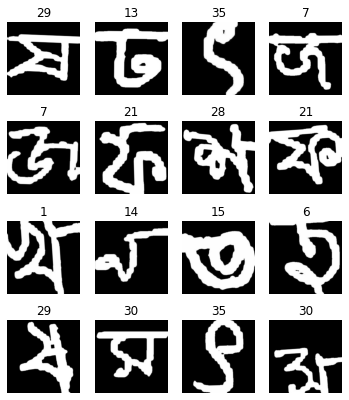

In [30]:
dls.show_batch(max_n=16, figsize=(6,7))

In [31]:
learn = cnn_learner(dls, mobilenet_v3_small, pretrained=True, metrics=[error_rate,accuracy]).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [32]:
learn.load(model_save_path)

In [33]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm

In [34]:
class TFLiteNetwork(nn.Module):
    def __init__(self,my_model):
        super(TFLiteNetwork, self).__init__()
        self.my_model = my_model
        self.softy = nn.Softmax(dim=1)
        self.trans = transforms.Compose([transforms.Resize(224),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

    def forward(self, x):
        x = x.swapaxes(1,3)
        x = x.swapaxes(3,2)
        x = self.trans(x)
        logits = self.my_model(x)
        soft_logit = self.softy(logits)
        
        return soft_logit

In [35]:
import onnx
import onnxruntime as ort
from onnx_tf.backend import prepare
import tensorflow as tf

def torch2tflite(torch_model,tflite_model_path,tflite_model_name = 'default.tflite'):
    onnx_model_name = 'torch_model.onnx'
    tf_model_name = 'tf_model'
    tflite_model_name

    torch_model.eval()
    sample_input = torch.rand((1, 224, 224, 3))
    torch.onnx.export(
        torch_model,                  # PyTorch Model
        sample_input,                    # Input tensor
        onnx_model_name,        # Output file (eg. 'output_model.onnx')
        opset_version=12,       # Operator support version
        input_names=['input'],   # Input tensor name (arbitary)
        output_names=['output'] # Output tensor name (arbitary)
    )


    onnx_model = onnx.load(onnx_model_name)
    onnx.checker.check_model(onnx_model)
    onnx.helper.printable_graph(onnx_model.graph)

    ort_session = ort.InferenceSession(onnx_model_name)
    outputs = ort_session.run(
        None,
        {'input': np.random.randn(1, 224, 224, 3).astype(np.float32)}
    )

    onnx_model = onnx.load(onnx_model_name)

    tf_rep = prepare(onnx_model)

    tf_rep.export_graph(tf_model_name)

    tf_model = tf.saved_model.load(tf_model_name)
    tf_model.trainable = False

    input_tensor = tf.random.uniform([1, 224, 224, 3])
    out = tf_model(**{'input': input_tensor})

    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_name)
    tflite_model = converter.convert()

    # Save the model
    with open(tflite_model_path/tflite_model_name, 'wb') as f:
        f.write(tflite_model)



In [36]:
torch_network = TFLiteNetwork(learn.model)
torch2tflite(torch_network,tflite_save_path,tflite_model_name)

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


In [ ]:
mamod.eval()
sample_input = torch.rand((1, 224, 224, 3))

In [ ]:
torch.onnx.export(
    mamod,                  # PyTorch Model
    sample_input,                    # Input tensor
    'mamod.onnx',        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'] # Output tensor name (arbitary)
)

In [ ]:
import onnx

# Load the ONNX model
onnxmodel = onnx.load("mamod.onnx")

# Check that the IR is well formed
onnx.checker.check_model(onnxmodel)

# Print a Human readable representation of the graph
onnx.helper.printable_graph(onnxmodel.graph)

'graph torch-jit-export (\n  %input[FLOAT, 1x224x224x3]\n) initializers (\n  %my_model.0.0.1.block.1.fc1.weight[FLOAT, 8x16x1x1]\n  %my_model.0.0.1.block.1.fc1.bias[FLOAT, 8]\n  %my_model.0.0.1.block.1.fc2.weight[FLOAT, 16x8x1x1]\n  %my_model.0.0.1.block.1.fc2.bias[FLOAT, 16]\n  %my_model.0.0.4.block.2.fc1.weight[FLOAT, 24x96x1x1]\n  %my_model.0.0.4.block.2.fc1.bias[FLOAT, 24]\n  %my_model.0.0.4.block.2.fc2.weight[FLOAT, 96x24x1x1]\n  %my_model.0.0.4.block.2.fc2.bias[FLOAT, 96]\n  %my_model.0.0.5.block.2.fc1.weight[FLOAT, 64x240x1x1]\n  %my_model.0.0.5.block.2.fc1.bias[FLOAT, 64]\n  %my_model.0.0.5.block.2.fc2.weight[FLOAT, 240x64x1x1]\n  %my_model.0.0.5.block.2.fc2.bias[FLOAT, 240]\n  %my_model.0.0.6.block.2.fc1.weight[FLOAT, 64x240x1x1]\n  %my_model.0.0.6.block.2.fc1.bias[FLOAT, 64]\n  %my_model.0.0.6.block.2.fc2.weight[FLOAT, 240x64x1x1]\n  %my_model.0.0.6.block.2.fc2.bias[FLOAT, 240]\n  %my_model.0.0.7.block.2.fc1.weight[FLOAT, 32x120x1x1]\n  %my_model.0.0.7.block.2.fc1.bias[FLOAT,

In [ ]:
import onnxruntime as ort

ort_session = ort.InferenceSession('mamod.onnx')

outputs = ort_session.run(
    None,
    {'input': np.random.randn(1, 224, 224, 3).astype(np.float32)}
)

In [ ]:
import onnx
onnx_model = onnx.load('mamod.onnx')

In [ ]:
from onnx_tf.backend import prepare

tf_rep = prepare(onnx_model)

In [ ]:
tf_rep.export_graph('mamod')

INFO:tensorflow:Assets written to: mamod/assets


INFO:tensorflow:Assets written to: mamod/assets


In [ ]:
import tensorflow as tf

tf_model = tf.saved_model.load('mamod')
tf_model.trainable = False

input_tensor = tf.random.uniform([1, 224, 224, 3])
out = tf_model(**{'input': input_tensor})

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('mamod')
tflite_model = converter.convert()

# Save the model
with open('my.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model = models.mobilenet_v3_small(pretrained = True, progress = True)
model.classifier = nn.Sequential(nn.Linear(576, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 4))

In [ ]:
model_dict_file = f'/content/drive/MyDrive/Colab Notebooks/Grape/mobile_small/mobilenet_v3_small.pt'

In [ ]:
state_dict = torch.load(model_dict_file,map_location='cpu')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [ ]:
mamod = NeuralNetwork(model)

In [ ]:
mamod.eval()
sample_input = torch.rand((1, 224, 224, 3))